# Analyzing XMM-Newton and Chandra light curves, with some digressions

Let us begin by importing all the possible dependencies.

In [1]:
import os
import glob
import shutil
from pathlib import Path
from warnings import warn

import numpy as np
#from pysas.wrapper import Wrapper as w

from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy import visualization as avis
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
#from astroquery.simbad import Simbad

import matplotlib.pyplot as plt

from astropy.timeseries import LombScargle, LombScargleMultiband

from astropy.time import Time

import copy
import pickle
from astropy.timeseries import TimeSeries, BinnedTimeSeries
from pprint import pprint

from scipy.optimize import minimize


%matplotlib inline

Set up loading the XMM and Chandra light curves. Read in Chandra and plot it.

In [2]:
xmmObsids = ['0865040'+str(i)+'01' for i in range(2,8)]

obsidExposureMap = {'0865040201':'3790','0865040301':'3792','0865040401':'3795','0865040501':'3805','0865040601':'3798','0865040701':'3802'}

In [3]:
chandraObsids = [20160,20161,21946,21947,21948,21950,21951,21952,21953,21954,21965]

In [4]:
lcChandraFull = {}

for obsid in chandraObsids:
    lcChandraFull[obsid] = Table(fits.open('hltau_data_r2d2/hltau_'+str(obsid)+'_sub_lc_500_8000.fits')[1].data)
    
lcChandraFull[20160]

TIME_BIN,TIME_MIN,TIME,TIME_MAX,COUNTS,STAT_ERR,AREA,EXPOSURE,COUNT_RATE,COUNT_RATE_ERR,BG_COUNTS,BG_ERR,BG_AREA,BG_EXPOSURE,BG_RATE,NORM_BG_COUNTS,NORM_BG_ERR,NET_COUNTS,NET_ERR,NET_RATE,ERR_RATE
int32,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,656921960.0061,656922960.0061,656923960.0061,18,4.242640687119285,51.91342212951351,1259.5381555541312,0.014290952537345672,0.0033684098162574073,11.0,3.3166247903554,11680.519979140541,1259.5381555541312,0.008733359883933466,0.04888888888888889,0.014740554623801777,17.95111111111111,4.242666294201161,0.01425213760452819,0.0033684301467902804
2,656923960.0061,656924960.0061,656925960.0061,17,4.123105625617661,51.91342212951351,1973.86852762142,0.008612529032258084,0.0020888451119822787,14.0,3.7416573867739413,11680.519979140541,1973.86852762142,0.007092670967741952,0.06222222222222222,0.01662958838566196,16.93777777777778,4.123139161271406,0.008581006050179231,0.002088862101793543
3,656925960.0061,656926960.0061,656927960.0061,20,4.47213595499958,51.91342212951351,1973.86852762142,0.010132387096774217,0.002265670632272889,10.0,3.1622776601683795,11680.519979140541,1973.86852762142,0.005066193548387108,0.044444444444444446,0.014054567378526131,19.955555555555556,4.47215803956705,0.010109870681003608,0.002265681820742213
4,656927960.0061,656928960.0061,656929960.0061,13,3.605551275463989,51.91342212951351,1973.86852762142,0.006586051612903241,0.0018266420610134574,12.0,3.4641016151377544,11680.519979140541,1973.86852762142,0.006079432258064531,0.05333333333333333,0.01539600717839002,12.946666666666667,3.6055841464368896,0.00655903191397851,0.0018266587140845412
5,656929960.0061,656930960.0061,656931960.0061,23,4.795831523312719,51.91342212951351,1973.86852762142,0.01165224516129035,0.0024296610722558416,16.0,4.0,11680.519979140541,1973.86852762142,0.008105909677419374,0.07111111111111111,0.017777777777777778,22.92888888888889,4.79586447362545,0.011616218896057375,0.0024296777655220194
6,656931960.0061,656932960.0061,656933960.0061,16,4.0,51.91342212951351,1973.86852762142,0.008105909677419374,0.0020264774193548434,9.0,3.0,11680.519979140541,1973.86852762142,0.004559574193548398,0.04,0.013333333333333332,15.96,4.000022222160494,0.008085644903225825,0.002026488677531456
7,656933960.0061,656934960.0061,656935960.0061,13,3.605551275463989,51.91342212951351,1973.86852762142,0.006586051612903241,0.0018266420610134574,20.0,4.47213595499958,11680.519979140541,1973.86852762142,0.010132387096774217,0.08888888888888889,0.01987615979999813,12.911111111111111,3.605606060252339,0.006541018781362022,0.001826669816047586
8,656935960.0061,656936960.0061,656937960.0061,18,4.242640687119285,51.91342212951351,1973.86852762142,0.009119148387096796,0.002149403887720837,15.0,3.872983346207417,11680.519979140541,1973.86852762142,0.0075992903225806634,0.06666666666666667,0.01721325931647741,17.933333333333334,4.242675605828978,0.009085373763440882,0.002149421578215014
9,656937960.0061,656938960.0061,656939960.0061,15,3.872983346207417,51.91342212951351,1973.86852762142,0.0075992903225806634,0.0019621283241566733,15.0,3.872983346207417,11680.519979140541,1973.86852762142,0.0075992903225806634,0.06666666666666667,0.01721325931647741,14.933333333333334,3.873021597705892,0.00756551569892475,0.0019621477031061523


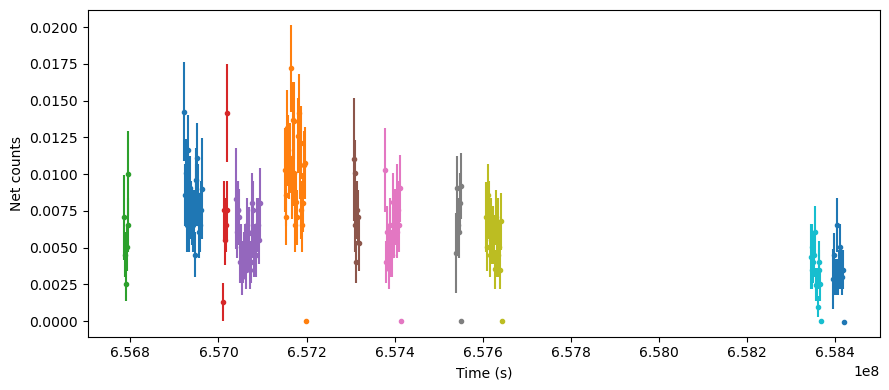

In [5]:
#%matplotlib notebook

plt.figure(figsize=(9.,4.))

for obsid in chandraObsids:
    plt.errorbar(lcChandraFull[obsid]['TIME_MIN'],lcChandraFull[obsid]['NET_RATE'],yerr=lcChandraFull[obsid]['ERR_RATE'],fmt='.')

plt.xlabel('Time (s)')
plt.ylabel('Net counts')
plt.tight_layout()
plt.show()

Read in the XMM data.

In [6]:
lcMOS1hard = {}
lcMOS2hard = {}
lcPNhard   = {}

lcMOS1soft = {}
lcMOS2soft = {}
lcPNsoft   = {}


for obsid in xmmObsids:
    #fits.open('/data/swolk/SILVERBERG/xztau_data/0865040401/XZTau_3795_0865040401_EMOS1_S001_hard_lc_clean.fits')
    lcMOS1hard[obsid] = Table(fits.open('hltau_data_r2d2/HLTau_'+obsidExposureMap[obsid]+'_'+obsid+'_EMOS1_S001_hard_lc_clean.fits')[1].data)
    lcMOS2hard[obsid] = Table(fits.open('hltau_data_r2d2/HLTau_'+obsidExposureMap[obsid]+'_'+obsid+'_EMOS2_S002_hard_lc_clean.fits')[1].data)
    lcPNhard[obsid]   = Table(fits.open('hltau_data_r2d2/HLTau_'+obsidExposureMap[obsid]+'_'+obsid+'_EPN_S003_hard_lc_clean.fits')[1].data)
    
    lcMOS1soft[obsid] = Table(fits.open('hltau_data_r2d2/HLTau_'+obsidExposureMap[obsid]+'_'+obsid+'_EMOS1_S001_soft_lc_clean.fits')[1].data)
    lcMOS2soft[obsid] = Table(fits.open('hltau_data_r2d2/HLTau_'+obsidExposureMap[obsid]+'_'+obsid+'_EMOS2_S002_soft_lc_clean.fits')[1].data)
    lcPNsoft[obsid]   = Table(fits.open('hltau_data_r2d2/HLTau_'+obsidExposureMap[obsid]+'_'+obsid+'_EPN_S003_soft_lc_clean.fits')[1].data)

In [7]:
for obsid in xmmObsids:
    lcMOS1hard[obsid]['obsid'] = obsid
    lcMOS2hard[obsid]['obsid'] = obsid
    lcPNhard[obsid]['obsid'] = obsid
    lcMOS1soft[obsid]['obsid'] = obsid
    lcMOS2soft[obsid]['obsid'] = obsid
    lcPNsoft[obsid]['obsid'] = obsid
    
lcPNhard['0865040201']

TIME,RATE,ERROR,FRACEXP,BACKV,BACKE,obsid
float64,float32,float32,float32,float32,float32,str10
714157562.849716,0.10381433,0.017666431,0.85779136,0.005006293,0.00072259613,0865040201
714158562.849716,0.108376116,0.017977327,0.862244,0.0050841994,0.0007263142,0865040201
714159562.849716,0.10967099,0.017562782,0.86078167,0.0022865797,0.00048750045,0865040201
714160562.849716,0.09656203,0.016515592,0.8606384,0.0021830078,0.00047637135,0865040201
714161562.849716,0.100308895,0.016743224,0.8596352,0.001769259,0.00042910836,0865040201
714162562.849716,0.106958576,0.017093414,0.8626831,0.0010370635,0.0003279483,0865040201
714163562.849716,0.10485034,0.017114786,0.86236095,0.001971157,0.00045221444,0865040201
714164562.849716,0.13418913,0.019140748,0.8590756,0.0010414185,0.00032932544,0865040201
714165562.849716,0.14320596,0.019814419,0.8620614,0.0015567173,0.00040194267,0865040201


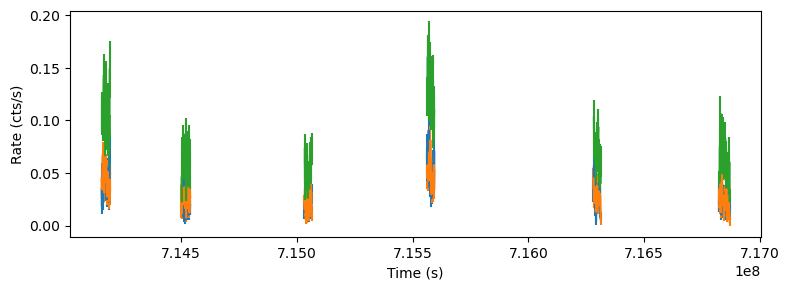

In [8]:
#%matplotlib notebook

plt.figure(figsize=(8.,3.))

for obsid in xmmObsids:
    plt.errorbar(lcMOS1hard[obsid]['TIME'],lcMOS1hard[obsid]['RATE'],yerr=lcMOS1hard[obsid]['ERROR'],color='C0')
    plt.errorbar(lcMOS2hard[obsid]['TIME'],lcMOS2hard[obsid]['RATE'],yerr=lcMOS2hard[obsid]['ERROR'],color='C1')
    plt.errorbar(lcPNhard[obsid]['TIME'],  lcPNhard[obsid]['RATE'],  yerr=lcPNhard[obsid]['ERROR'],  color='C2')
    
plt.xlabel('Time (s)')
plt.ylabel('Rate (cts/s)')
#plt.xlim([7.1415e8,7.1420e8])
plt.tight_layout()
plt.show()

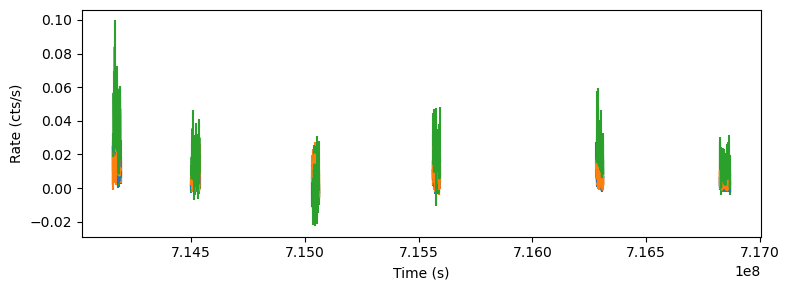

In [9]:
#%matplotlib notebook

plt.figure(figsize=(8.,3.))

for obsid in xmmObsids:
    plt.errorbar(lcMOS1soft[obsid]['TIME'],lcMOS1soft[obsid]['RATE'],yerr=lcMOS1soft[obsid]['ERROR'],color='C0')
    plt.errorbar(lcMOS2soft[obsid]['TIME'],lcMOS2soft[obsid]['RATE'],yerr=lcMOS2soft[obsid]['ERROR'],color='C1')
    plt.errorbar(lcPNsoft[obsid]['TIME'],  lcPNsoft[obsid]['RATE'],  yerr=lcPNsoft[obsid]['ERROR'],  color='C2')
    
plt.xlabel('Time (s)')
plt.ylabel('Rate (cts/s)')
plt.tight_layout()
plt.show()

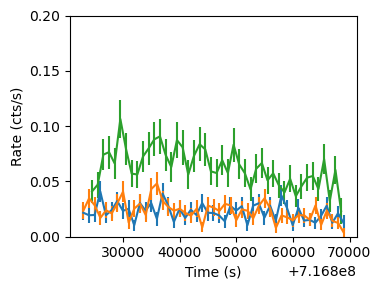

In [10]:
# Look at individual obsids to search for evidence of flaring.

plt.figure(figsize=(4.,3.))

for obsid in ['0865040501']:
    plt.errorbar(lcMOS1hard[obsid]['TIME'],lcMOS1hard[obsid]['RATE'],yerr=lcMOS1hard[obsid]['ERROR'],color='C0')
    plt.errorbar(lcMOS2hard[obsid]['TIME'],lcMOS2hard[obsid]['RATE'],yerr=lcMOS2hard[obsid]['ERROR'],color='C1')
    plt.errorbar(lcPNhard[obsid]['TIME'],  lcPNhard[obsid]['RATE'],  yerr=lcPNhard[obsid]['ERROR'],  color='C2')
    
plt.xlabel('Time (s)')
plt.ylabel('Rate (cts/s)')
plt.ylim([0.,0.2])
plt.tight_layout()
plt.show()

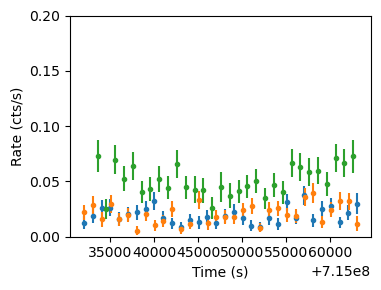

In [11]:
# Look at individual obsids to search for evidence of flaring.

plt.figure(figsize=(4.,3.))

for obsid in ['0865040401']:
    plt.errorbar(lcMOS1hard[obsid]['TIME'],lcMOS1hard[obsid]['RATE'],yerr=lcMOS1hard[obsid]['ERROR'],color='C0',fmt='.')
    plt.errorbar(lcMOS2hard[obsid]['TIME'],lcMOS2hard[obsid]['RATE'],yerr=lcMOS2hard[obsid]['ERROR'],color='C1',fmt='.')
    plt.errorbar(lcPNhard[obsid]['TIME'],  lcPNhard[obsid]['RATE'],  yerr=lcPNhard[obsid]['ERROR'],  color='C2',fmt='.')
    
plt.xlabel('Time (s)')
plt.ylabel('Rate (cts/s)')
plt.ylim([0.,0.2])
plt.tight_layout()
plt.show()

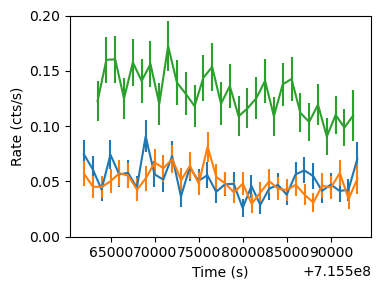

In [12]:
# Look at individual obsids to search for evidence of flaring.

plt.figure(figsize=(4.,3.))

for obsid in ['0865040601']:
    plt.errorbar(lcMOS1hard[obsid]['TIME'],lcMOS1hard[obsid]['RATE'],yerr=lcMOS1hard[obsid]['ERROR'],color='C0')
    plt.errorbar(lcMOS2hard[obsid]['TIME'],lcMOS2hard[obsid]['RATE'],yerr=lcMOS2hard[obsid]['ERROR'],color='C1')
    plt.errorbar(lcPNhard[obsid]['TIME'],  lcPNhard[obsid]['RATE'],  yerr=lcPNhard[obsid]['ERROR'],  color='C2')
    
plt.xlabel('Time (s)')
plt.ylabel('Rate (cts/s)')
plt.ylim([0.,0.2])
plt.tight_layout()
plt.show()

Let's get the average count rate for each PN light curve, and then plot the light curves against their average count rate, in six close-together windows that will compress the x-axis visibly enough to make visual examination of if it's down-sloping or not possible.

In [15]:
avgrate201 = np.sum([lcPNhard['0865040201']['RATE'][i]*1000 for i in range(len(lcPNhard['0865040201']['RATE']))])/((lcPNhard['0865040201']['TIME'][-1] - lcPNhard['0865040201']['TIME'][0])+1000.)
avgrate301 = np.sum([lcPNhard['0865040301']['RATE'][i]*1000 for i in range(len(lcPNhard['0865040301']['RATE']))])/((lcPNhard['0865040301']['TIME'][-1] - lcPNhard['0865040301']['TIME'][0])+1000.)
avgrate401 = np.sum([lcPNhard['0865040401']['RATE'][i]*1000 for i in range(len(lcPNhard['0865040401']['RATE']))])/((lcPNhard['0865040401']['TIME'][-1] - lcPNhard['0865040401']['TIME'][0])+1000.)
avgrate601 = np.sum([lcPNhard['0865040601']['RATE'][i]*1000 for i in range(len(lcPNhard['0865040601']['RATE']))])/((lcPNhard['0865040601']['TIME'][-1] - lcPNhard['0865040601']['TIME'][0])+1000.)
avgrate701 = np.sum([lcPNhard['0865040701']['RATE'][i]*1000 for i in range(len(lcPNhard['0865040701']['RATE']))])/((lcPNhard['0865040701']['TIME'][-1] - lcPNhard['0865040701']['TIME'][0])+1000.)
avgrate501 = np.sum([lcPNhard['0865040501']['RATE'][i]*1000 for i in range(len(lcPNhard['0865040501']['RATE']))])/((lcPNhard['0865040501']['TIME'][-1] - lcPNhard['0865040501']['TIME'][0])+1000.)

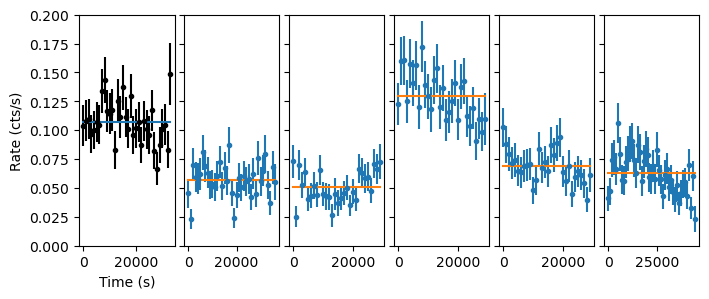

In [16]:
#Plot each XMM obsid light curve against its average rate, in six close-together windows that will compress the plot enough to see
#whether 

fig = plt.figure(figsize=(8.,3.))

ax = [plt.subplot(1,6,i+1) for i in range(6)]
ax[0].errorbar(lcPNhard['0865040201']['TIME'] - lcPNhard['0865040201']['TIME'][0],  lcPNhard['0865040201']['RATE'],  yerr=lcPNhard['0865040201']['ERROR'],fmt='.',label='201',color='k')
ax[0].plot([0.,lcPNhard['0865040201']['TIME'][-1] - lcPNhard['0865040201']['TIME'][0]],[avgrate201,avgrate201])
ax[0].set_ylim([0.,0.2])

ax[1].errorbar(lcPNhard['0865040301']['TIME'] - lcPNhard['0865040301']['TIME'][0],  lcPNhard['0865040301']['RATE'],  yerr=lcPNhard['0865040301']['ERROR'],fmt='.',label='301')
ax[1].plot([0.,lcPNhard['0865040301']['TIME'][-1] - lcPNhard['0865040301']['TIME'][0]],[avgrate301,avgrate301])
ax[1].set_ylim([0.,0.2])
ax[1].set_yticklabels([])

ax[2].errorbar(lcPNhard['0865040401']['TIME'] - lcPNhard['0865040401']['TIME'][0],  lcPNhard['0865040401']['RATE'],  yerr=lcPNhard['0865040401']['ERROR'],fmt='.',label='401')
ax[2].plot([0.,lcPNhard['0865040401']['TIME'][-1] - lcPNhard['0865040401']['TIME'][0]],[avgrate401,avgrate401])
ax[2].set_ylim([0.,0.2])
ax[2].set_yticklabels([])

ax[3].errorbar(lcPNhard['0865040601']['TIME'] - lcPNhard['0865040601']['TIME'][0],  lcPNhard['0865040601']['RATE'],  yerr=lcPNhard['0865040601']['ERROR'],fmt='.',label='601')
ax[3].plot([0.,lcPNhard['0865040601']['TIME'][-1] - lcPNhard['0865040601']['TIME'][0]],[avgrate601,avgrate601])
ax[3].set_ylim([0.,0.2])
ax[3].set_yticklabels([])

ax[4].errorbar(lcPNhard['0865040701']['TIME'] - lcPNhard['0865040701']['TIME'][0],  lcPNhard['0865040701']['RATE'],  yerr=lcPNhard['0865040701']['ERROR'],fmt='.',label='701')
ax[4].plot([0.,lcPNhard['0865040701']['TIME'][-1] - lcPNhard['0865040701']['TIME'][0]],[avgrate701,avgrate701])
ax[4].set_ylim([0.,0.2])
ax[4].set_yticklabels([])

ax[5].errorbar(lcPNhard['0865040501']['TIME'] - lcPNhard['0865040501']['TIME'][0],  lcPNhard['0865040501']['RATE'],  yerr=lcPNhard['0865040501']['ERROR'],fmt='.',label='501')
ax[5].plot([0.,lcPNhard['0865040501']['TIME'][-1] - lcPNhard['0865040501']['TIME'][0]],[avgrate501,avgrate501])
ax[5].set_ylim([0.,0.2])
ax[5].set_yticklabels([])


plt.subplot(161)
plt.xlabel('Time (s)')
plt.ylabel('Rate (cts/s)')
#plt.label_outer()
#plt.xlim([-1000.,55000.])
#plt.ylim([0.,0.2])
#plt.legend(loc='best')
plt.subplots_adjust(wspace=0.1, hspace=0.)
plt.show()

In [17]:
for i in range(len(lcPNhard['0865040601']['RATE'])):
    print(lcPNhard['0865040601']['ERROR'][i])

0.018516982
0.02095848
0.021068357
0.018795177
0.02111344
0.019980006
0.021024698
0.018961906
0.022198075
0.02017364
0.019336618
0.019254168
0.020763187
0.021419065
0.019318352
0.019968096
0.017897896
0.018041875
0.018887535
0.019987952
0.01777197
0.019649914
0.019902578
0.01769429
0.017386444
0.018266164
0.016573079
0.017529584
0.016780822
0.022711627


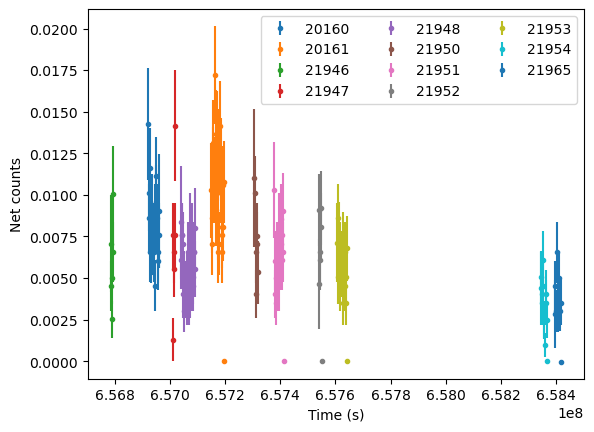

In [18]:
#Plot Chandra data with obsids labeled

plt.figure()

for obsid in chandraObsids:
    plt.errorbar(lcChandraFull[obsid]['TIME_MIN'],lcChandraFull[obsid]['NET_RATE'],yerr=lcChandraFull[obsid]['ERR_RATE'],fmt='.',label=str(obsid))

plt.xlabel('Time (s)')
plt.ylabel('Net counts')
plt.legend(loc='upper right',ncol=3)
plt.show()

In [19]:
#Generate one big light curve for each XMM detector, across obsids

lcMOS1hardFull = copy.deepcopy(lcMOS1hard['0865040201'])
lcMOS2hardFull = copy.deepcopy(lcMOS2hard['0865040201'])
lcPNhardFull   = copy.deepcopy(lcPNhard['0865040201'])

for obsid in xmmObsids[1:]:
    for i in range(len(lcMOS1hard[obsid]['TIME'])):
        lcMOS1hardFull.add_row({x: lcMOS1hard[obsid][x][i] for x in lcMOS1hard[obsid].colnames})
    for i in range(len(lcMOS2hard[obsid]['TIME'])):
        lcMOS2hardFull.add_row({x: lcMOS2hard[obsid][x][i] for x in lcMOS2hard[obsid].colnames})
    for i in range(len(lcPNhard[obsid]['TIME'])):
        lcPNhardFull.add_row({x: lcPNhard[obsid][x][i] for x in lcPNhard[obsid].colnames})
        
lcPNhardFull

TIME,RATE,ERROR,FRACEXP,BACKV,BACKE,obsid
float64,float32,float32,float32,float32,float32,str10
714157562.849716,0.10381433,0.017666431,0.85779136,0.005006293,0.00072259613,0865040201
714158562.849716,0.108376116,0.017977327,0.862244,0.0050841994,0.0007263142,0865040201
714159562.849716,0.10967099,0.017562782,0.86078167,0.0022865797,0.00048750045,0865040201
714160562.849716,0.09656203,0.016515592,0.8606384,0.0021830078,0.00047637135,0865040201
714161562.849716,0.100308895,0.016743224,0.8596352,0.001769259,0.00042910836,0865040201
714162562.849716,0.106958576,0.017093414,0.8626831,0.0010370635,0.0003279483,0865040201
714163562.849716,0.10485034,0.017114786,0.86236095,0.001971157,0.00045221444,0865040201
714164562.849716,0.13418913,0.019140748,0.8590756,0.0010414185,0.00032932544,0865040201
714165562.849716,0.14320596,0.019814419,0.8620614,0.0015567173,0.00040194267,0865040201


In [20]:
lcMOS1hardFull.sort('TIME')
lcMOS2hardFull.sort('TIME')
lcPNhardFull.sort('TIME')

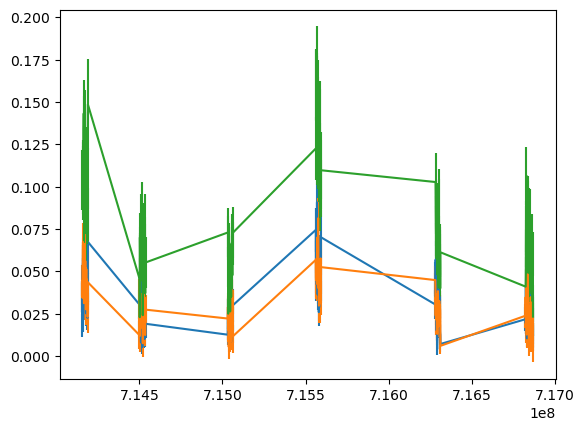

In [21]:
#Plot

plt.figure()

plt.errorbar(lcMOS1hardFull['TIME'],lcMOS1hardFull['RATE'],yerr=lcMOS1hardFull['ERROR'])
plt.errorbar(lcMOS2hardFull['TIME'],lcMOS2hardFull['RATE'],yerr=lcMOS1hardFull['ERROR'])
plt.errorbar(lcPNhardFull['TIME'],  lcPNhardFull['RATE'],  yerr=lcPNhardFull['ERROR'])

plt.show()

In [22]:
# Put time in MJD

lcMOS1hardFull['TIMEMJD'] = Time(lcMOS1hardFull['TIME'],format='cxcsec').mjd
lcMOS2hardFull['TIMEMJD'] = Time(lcMOS2hardFull['TIME'],format='cxcsec').mjd
lcPNhardFull['TIMEMJD']   = Time(lcPNhardFull['TIME'],format='cxcsec').mjd

lcPNhardFull

TIME,RATE,ERROR,FRACEXP,BACKV,BACKE,obsid,TIMEMJD
float64,float32,float32,float32,float32,float32,str10,float64
714157562.849716,0.10381433,0.017666431,0.85779136,0.005006293,0.00072259613,0865040201,59079.71253298283
714158562.849716,0.108376116,0.017977327,0.862244,0.0050841994,0.0007263142,0865040201,59079.7241070569
714159562.849716,0.10967099,0.017562782,0.86078167,0.0022865797,0.00048750045,0865040201,59079.73568113097
714160562.849716,0.09656203,0.016515592,0.8606384,0.0021830078,0.00047637135,0865040201,59079.747255205046
714161562.849716,0.100308895,0.016743224,0.8596352,0.001769259,0.00042910836,0865040201,59079.75882927912
714162562.849716,0.106958576,0.017093414,0.8626831,0.0010370635,0.0003279483,0865040201,59079.77040335319
714163562.849716,0.10485034,0.017114786,0.86236095,0.001971157,0.00045221444,0865040201,59079.781977427265
714164562.849716,0.13418913,0.019140748,0.8590756,0.0010414185,0.00032932544,0865040201,59079.793551501345
714165562.849716,0.14320596,0.019814419,0.8620614,0.0015567173,0.00040194267,0865040201,59079.80512557542


In [23]:
# Stash this in a file

lcMOS1hardFull.write('hltau_tables/lcMOS1hardFull.ecsv',overwrite=True)
lcMOS2hardFull.write('hltau_tables/lcMOS2hardFull.ecsv',overwrite=True)
lcPNhardFull.write('hltau_tables/lcPNhardFull.ecsv',overwrite=True)

In [24]:
# Generate Lomb-Scargle periodograms for the data

lsMOS1hard = LombScargle(lcMOS1hardFull['TIMEMJD'],lcMOS1hardFull['RATE'],lcMOS1hardFull['ERROR'],fit_mean=True)
lsMOS2hard = LombScargle(lcMOS2hardFull['TIMEMJD'],lcMOS2hardFull['RATE'],lcMOS2hardFull['ERROR'],fit_mean=True)
lsPNhard   = LombScargle(lcPNhardFull['TIMEMJD'],  lcPNhardFull['RATE'],  lcPNhardFull['ERROR'],fit_mean=True)

In [25]:
testTimeFull = np.linspace(53000,59250,((59250-53000)*2)+1) #testing time baseline to plot on

In [26]:
#Find the minimum frequency that can be seen--defined as the longest period for which one cycle can be seen

minfreqMOS1 = 1./(max(lcMOS1hardFull['TIMEMJD'])-min(lcMOS1hardFull['TIMEMJD']))
minfreqMOS2 = 1./(max(lcMOS2hardFull['TIMEMJD'])-min(lcMOS2hardFull['TIMEMJD']))
minfreqPN = 1./(max(lcPNhardFull['TIMEMJD'])-min(lcPNhardFull['TIMEMJD']))

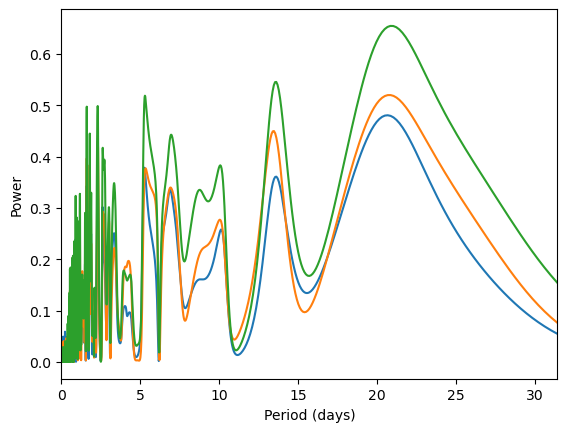

In [27]:
%matplotlib inline

testFreqMOS1, testPowerMOS1 = lsMOS1hard.autopower(samples_per_peak=75,minimum_frequency=minfreqMOS1)
testFreqMOS2, testPowerMOS2 = lsMOS2hard.autopower(samples_per_peak=75,minimum_frequency=minfreqMOS2)
testFreqPN,   testPowerPN   = lsPNhard.autopower(samples_per_peak=75,minimum_frequency=minfreqPN)
plt.figure()
plt.plot((1./testFreqMOS1),testPowerMOS1)
plt.plot((1./testFreqMOS2),testPowerMOS2)
plt.plot((1./testFreqPN),  testPowerPN)
plt.xlim([0.,max([1./minfreqMOS1,1./minfreqMOS2,1./minfreqPN])])
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.savefig('hltau_local_plots/LombScargleXMMLC_20240709.png')
plt.savefig('hltau_local_plots/LombScargleXMMLC_20240709.pdf')

So we see one peak that looks like approximately the same period in all three periodograms. We also see another peak next to it, lower, and the frequency on _that_ one seems to differ between detectors, despite all the data being basically the same. Possibly this is an artifact of having three different detectors, each of which turned on at different times? Also there's that weird _definitely not a period here_ dip around 6.5 days or so in all three detectors. Odd.

Let's get our best frequency for each detector, compare them.

In [28]:
#testFreqXMMem1[np.argmax(testPowerXMMem1)]
testBestFreqMOS1 = testFreqMOS1[np.argmax(testPowerMOS1)]
testBestFreqMOS2 = testFreqMOS2[np.argmax(testPowerMOS2)]
testBestFreqPN   = testFreqPN[np.argmax(testPowerPN)]

print(testBestFreqMOS1,testBestFreqMOS2,testBestFreqPN)
print(1./testBestFreqMOS1,1./testBestFreqMOS2,1./testBestFreqPN)

0.04840786661185624 0.047983215403875984 0.04801864373043414
20.6577994444208 20.840620862586505 20.825244578205393


Wonder what that second peak is in each.

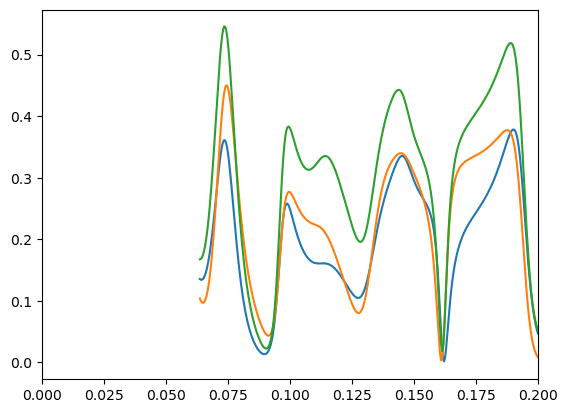

0.07346106073553622 0.07431028934228581 0.07351526872004518
13.612653969155902 13.457086614127286 13.602616400793119


In [29]:
plt.figure()
plt.plot(testFreqMOS1[75:],testPowerMOS1[75:])
plt.plot(testFreqMOS2[75:],testPowerMOS2[75:])
plt.plot(testFreqPN[75:],  testPowerPN[75:])
plt.xlim([0.,0.2])
plt.show()

testSecondBestFreqMOS1 = testFreqMOS1[np.argmax(testPowerMOS1[75:150]) + 75]
testSecondBestFreqMOS2 = testFreqMOS2[np.argmax(testPowerMOS2[75:150]) + 75]
testSecondBestFreqPN   = testFreqPN[np.argmax(testPowerPN[75:150]) + 75]

print(testSecondBestFreqMOS1,   testSecondBestFreqMOS2,   testSecondBestFreqPN)
print(1./testSecondBestFreqMOS1,1./testSecondBestFreqMOS2,1./testSecondBestFreqPN)

So _around_ 13.6 days, but with some variation. More variation than there was for the first peak. Interesting.

Let's try fitting all three jointly.

In [30]:
t = []
y = []
bands = []
dy = []
#for i, band in enumerate(['MOS1','MOS2','PN']):
t  += list(lcMOS1hardFull['TIMEMJD'])
y  += list(lcMOS1hardFull['RATE'])
dy += list(lcMOS1hardFull['ERROR'])
bands += ["MOS1"]*len(lcMOS1hardFull['TIMEMJD'])

t  += list(lcMOS2hardFull['TIMEMJD'])
y  += list(lcMOS2hardFull['RATE'])
dy += list(lcMOS2hardFull['ERROR'])
bands += ["MOS2"]*len(lcMOS2hardFull['TIMEMJD'])

t  += list(lcPNhardFull['TIMEMJD'])
y  += list(lcPNhardFull['RATE'])
dy += list(lcPNhardFull['ERROR'])
bands += ["PN"]*len(lcPNhardFull['TIMEMJD'])

#print(t)
#print(y)
#print(dy)
#print(bands)

In [31]:
lsMB = LombScargleMultiband(t,y,bands,dy,fit_mean=True)
testFreqMB, testPowerMB = lsMB.autopower(samples_per_peak=75,minimum_frequency=1./(max(t)-min(t)))

In [32]:
tMOS = []
yMOS = []
bandsMOS = []
dyMOS = []
#for i, band in enumerate(['MOS1','MOS2','PN']):
tMOS  += list(lcMOS1hardFull['TIMEMJD'])
yMOS  += list(lcMOS1hardFull['RATE'])
dyMOS += list(lcMOS1hardFull['ERROR'])
bandsMOS += ["MOS1"]*len(lcMOS1hardFull['TIMEMJD'])

tMOS  += list(lcMOS2hardFull['TIMEMJD'])
yMOS  += list(lcMOS2hardFull['RATE'])
dyMOS += list(lcMOS2hardFull['ERROR'])
bandsMOS += ["MOS2"]*len(lcMOS2hardFull['TIMEMJD'])

#print(tMOS)
#print(yMOS)
#print(dyMOS)
#print(bandsMOS)

In [33]:
lsMBMOS = LombScargleMultiband(tMOS,yMOS,bandsMOS,dyMOS,fit_mean=True)
testFreqMBMOS, testPowerMBMOS = lsMBMOS.autopower(samples_per_peak=50,minimum_frequency=1./(max(tMOS)-min(tMOS)))

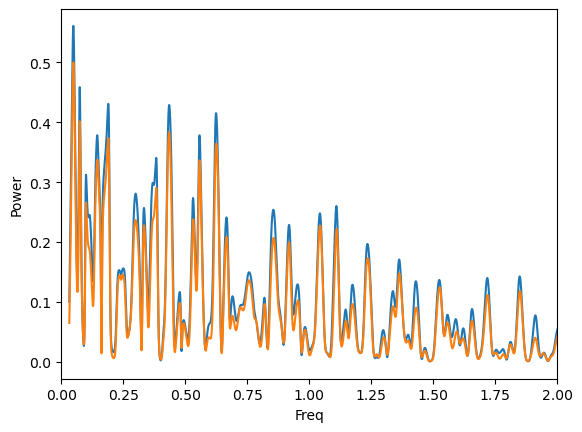

In [34]:
plt.figure()
plt.plot(testFreqMB,testPowerMB)
plt.plot(testFreqMBMOS,testPowerMBMOS)
plt.xlim([-0.0,2.])
plt.xlabel('Freq')
plt.ylabel('Power')
plt.show()

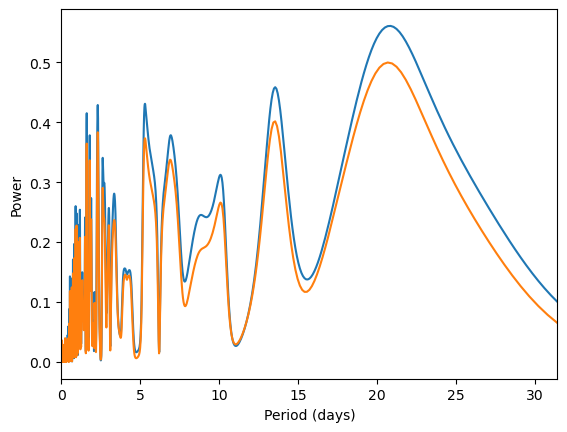

In [35]:
plt.figure()
plt.plot(1./testFreqMB,testPowerMB)
plt.plot(1./testFreqMBMOS,testPowerMBMOS)
plt.xlim([0.,(max(t)-min(t))])
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

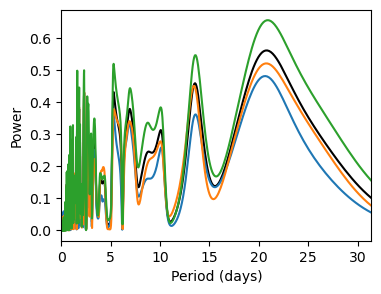

In [36]:
plt.figure(figsize=(4.,3.))
plt.plot(1./testFreqMB,   testPowerMB,  color='k')
plt.plot(1./testFreqMOS1, testPowerMOS1)#,alpha=0.75)
plt.plot(1./testFreqMOS2, testPowerMOS2)#,alpha=0.75)
plt.plot(1./testFreqPN,   testPowerPN)#,  alpha=0.75)
plt.xlim([0.,(max(t)-min(t))])
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

In [37]:
#Look at false alarm levels, and probability of false alarm at the strongest frequency for each

probabilities = [0.1, 0.05, 0.01]

print(lsMOS1hard.false_alarm_level(probabilities))
print(lsMOS2hard.false_alarm_level(probabilities))
print(lsPNhard.false_alarm_level(probabilities))

[0.08866128 0.09506648 0.10932877]
[0.08867854 0.09508356 0.10934546]
[0.09316002 0.09991177 0.11493461]


In [38]:
print(lsMOS1hard.false_alarm_probability(testPowerMOS1.max()))
print(lsMOS2hard.false_alarm_probability(testPowerMOS2.max()))
print(lsPNhard.false_alarm_probability(testPowerPN.max()))

1.775999999053809e-27
4.040881638996349e-31
1.1751715278343252e-43


In [39]:
testBestFreqMB = testFreqMB[np.argmax(testPowerMB)]
print(1./testBestFreqMB)
print(testBestFreqMB)

20.84078466174524
0.047982838277465245


Let's have a gander at the soft end, too.

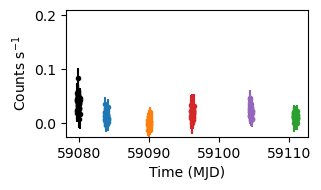

In [40]:
lcMOS1softFull = copy.deepcopy(lcMOS1soft['0865040201'])
lcMOS2softFull = copy.deepcopy(lcMOS2soft['0865040201'])
lcPNsoftFull   = copy.deepcopy(lcPNsoft['0865040201'])

for obsid in xmmObsids[1:]:
    for i in range(len(lcMOS1soft[obsid]['TIME'])):
        lcMOS1softFull.add_row({x: lcMOS1soft[obsid][x][i] for x in lcMOS1soft[obsid].colnames})
    for i in range(len(lcMOS2soft[obsid]['TIME'])):
        lcMOS2softFull.add_row({x: lcMOS2soft[obsid][x][i] for x in lcMOS2soft[obsid].colnames})
    for i in range(len(lcPNsoft[obsid]['TIME'])):
        lcPNsoftFull.add_row({x: lcPNsoft[obsid][x][i] for x in lcPNsoft[obsid].colnames})
        
lcMOS1softFull.sort('TIME')
lcMOS2softFull.sort('TIME')
lcPNsoftFull.sort('TIME')

lcMOS1softFull['TIMEMJD'] = Time(lcMOS1hardFull['TIME'],format='cxcsec').mjd
lcMOS2softFull['TIMEMJD'] = Time(lcMOS2hardFull['TIME'],format='cxcsec').mjd
lcPNsoftFull['TIMEMJD']   = Time(lcPNhardFull['TIME'],format='cxcsec').mjd



#Plot

colormap = {'0865040201':'k','0865040301':'C0','0865040401':'C1','0865040501':'C2','0865040601':'C3',
            '0865040701':'C4'}

plt.figure(figsize=(6.,2.))
plt.subplot(121)
#plt.errorbar(lcMOS1softFull['TIMEMJD'],lcMOS1softFull['RATE'],yerr=lcMOS1hardFull['ERROR'],fmt='.',label='MOS1')
#plt.errorbar(lcMOS2softFull['TIMEMJD'],lcMOS2softFull['RATE'],yerr=lcMOS1hardFull['ERROR'],fmt='.',label='MOS2')
#plt.errorbar(lcPNsoftFull['TIMEMJD'],  lcPNsoftFull['RATE'],  yerr=lcPNhardFull['ERROR'],  fmt='.',label='PN')
for i in range(len(lcPNsoftFull['TIMEMJD'])):
    plt.errorbar(lcPNsoftFull['TIMEMJD'][i],lcPNsoftFull['RATE'][i],yerr=lcPNhardFull['ERROR'][i],fmt='.',
                 color=colormap[lcPNsoftFull['obsid'][i]])

#plt.legend(loc='best')

#for obsid in xmmObsids:
    

plt.xlabel('Time (MJD)')
plt.ylabel(r'Counts s$^{-1}$')
plt.ylim([-0.025,0.21])
plt.tight_layout()
plt.savefig('hltau_local_plots/xmm_soft_light_curves_full.pdf')

In [ ]:
testLombScargleMOS1soft = LombScargle(lcMOS1softFull['TIMEMJD'],lcMOS1softFull['RATE'],lcMOS1softFull['ERROR'],fit_mean=True)
testLombScargleMOS2soft = LombScargle(lcMOS2softFull['TIMEMJD'],lcMOS2softFull['RATE'],lcMOS2softFull['ERROR'],fit_mean=True)
testLombScarglePNsoft   = LombScargle(lcPNsoftFull['TIMEMJD'],  lcPNsoftFull['RATE'],  lcPNsoftFull['ERROR'],fit_mean=True)

testFreqMOS1soft, testPowerMOS1soft = testLombScargleMOS1soft.autopower(samples_per_peak=75,minimum_frequency=minfreqMOS1)
testFreqMOS2soft, testPowerMOS2soft = testLombScargleMOS2soft.autopower(samples_per_peak=75,minimum_frequency=minfreqMOS2)
testFreqPNsoft,   testPowerPNsoft   = testLombScarglePNsoft.autopower(samples_per_peak=75,minimum_frequency=minfreqPN)


In [ ]:
plt.figure()
plt.plot((1./testFreqMOS1soft),testPowerMOS1soft)
plt.plot((1./testFreqMOS2soft),testPowerMOS2soft)
plt.plot((1./testFreqPNsoft),  testPowerPNsoft)
plt.xlim([0.,1./min(minfreqMOS1,minfreqMOS2,minfreqPN)])
plt.show()

Interesting that the strongest peak here is the same as the second-strongest peak in the hard data. Additional periodicity going through, or window function? Also a peak near our hard peak. Aliasing somehow?

In [ ]:
bestFreqPNsoft = testFreqPNsoft[np.argmax(testPowerPNsoft)]
print(bestFreqPNsoft)
print(1./bestFreqPNsoft)

In [ ]:
testLombScarglePNsoft.false_alarm_probability(max(testPowerPNsoft))

In [ ]:
testLombScarglePNsoft.false_alarm_level(probabilities)

What does the model of that look like compared to the data?

In [ ]:
modelPNsoft = testLombScarglePNsoft.model(testTimeFull,testFreqPNsoft[np.argmax(testPowerPNsoft)])
plt.figure()
plt.errorbar(lcPNsoftFull['TIMEMJD'],lcPNsoftFull['RATE'],yerr=lcPNsoftFull['ERROR'])
plt.plot(testTimeFull,modelPNsoft)
plt.xlim([59075,59115])
plt.show()

_shrug_ Sure? Mostly seems to be a factor of how much noise there is at soft energies, which is related to how little data there is to be had.

Let's mess around with the Chandra data, starting with cleaning out empty bins at the end of obsids.

In [ ]:
lcChandraFullFull = copy.deepcopy(lcChandraFull[chandraObsids[0]])

for obsid in chandraObsids[1:]:
    for i in range(len(lcChandraFull[obsid]['TIME_MIN'])):
        if lcChandraFull[obsid]['NET_COUNTS'][i] > 0.:
            lcChandraFullFull.add_row({x: lcChandraFull[obsid][x][i] for x in lcChandraFull[obsid].colnames})

In [ ]:
lcChandraFullFull['TIMEMJD'] = Time(lcChandraFullFull['TIME'],format='cxcsec').mjd
lcChandraFullFull

In [ ]:
lcChandraFullFull.sort('TIME')
lcChandraFullFull

In [ ]:
plt.figure(figsize=(4.,3.))
plt.errorbar(lcChandraFullFull['TIMEMJD'],lcChandraFullFull['NET_RATE'],yerr=lcChandraFullFull['ERR_RATE'],fmt='.')
plt.xlabel('MJD')
plt.ylabel('Rate (cts/s)')
plt.tight_layout()
plt.savefig('hltau_local_plots/plotChandraLC_20240709.png')
plt.savefig('hltau_local_plots/plotChandraLC_20240709.pdf')

Now let's periodogram it up, noting that we're not sensitive to things longer than ~19 days.

In [ ]:
testLombScargleChandra = LombScargle(lcChandraFullFull['TIMEMJD'],lcChandraFullFull['NET_RATE'],
                                     lcChandraFullFull['ERR_RATE'],fit_mean=True)

minFreqChandra = 1./(max(lcChandraFullFull['TIMEMJD'])-min(lcChandraFullFull['TIMEMJD']))

testFreqChandra, testPowerChandra = testLombScargleChandra.autopower(samples_per_peak=25,minimum_frequency=minFreqChandra)

plt.figure(figsize=(4.,3.))
plt.plot(1./testFreqChandra, testPowerChandra)
plt.xlim(0.,1./minFreqChandra)
plt.ylim([0.,1.02])
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.tight_layout()
plt.savefig('hltau_local_plots/LombScargleChandraLC_20240718.png')
plt.savefig('hltau_local_plots/LombScargleChandraLC_20240718.pdf')

In [ ]:
print(1./minFreqChandra)

In [ ]:
plt.figure()
plt.plot(testFreqChandra,testPowerChandra)
plt.xlabel('Frequency (c/d)')
plt.ylabel('Power')
plt.xlim([0.,5.])
plt.show()

Not much of anything here, particularly.

In [ ]:
modelChandra = testLombScargleChandra.model(testTimeFull,testFreqChandra[np.argmax(testPowerChandra)])

plt.figure()
plt.errorbar(lcChandraFullFull['TIMEMJD'],lcChandraFullFull['NET_RATE'],yerr=lcChandraFullFull['ERR_RATE'],fmt='.')
plt.plot(testTimeFull,modelChandra)
plt.xlim(58415.,58435.)
plt.xlabel('MJD')
plt.ylabel('Net Count Rate')
plt.show()

But let's look at the window function for the Chandra data, too. Just in case.

In [ ]:
lcChandraWindowTest = np.ones(len(lcChandraFullFull['TIMEMJD']))
lcChandraWindowTestUnc = np.array([lcChandraFullFull['ERR_RATE'][i]/lcChandraFullFull['NET_RATE'][i] 
                                   for i in range(len(lcChandraFullFull['TIMEMJD']))])

lsChandraWindow = LombScargle(lcChandraFullFull['TIMEMJD'],lcChandraWindowTest,
                                     lcChandraWindowTestUnc,fit_mean=False, center_data=False)

testFreqChandraWindow, testPowerChandraWindow = lsChandraWindow.autopower(samples_per_peak=25,minimum_frequency=minFreqChandra)

plt.figure(figsize=(4.,3.))
plt.plot(1./testFreqChandra, testPowerChandra)
plt.plot(1./testFreqChandraWindow, testPowerChandraWindow,color='C0',linestyle=':')
plt.xlim(0.,1./minFreqChandra)
plt.ylim([0.,1.02])
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.tight_layout()
plt.savefig('hltau_local_plots/LombScargleChandraWindowLC_20240702.png')
plt.savefig('hltau_local_plots/LombScargleChandraWindowLC_20240702.pdf')

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 2))
    
axes[0].errorbar(lcChandraFullFull['TIMEMJD'],lcChandraFullFull['NET_RATE'],yerr=lcChandraFullFull['ERR_RATE'],fmt='.')
axes[0].set_xlabel('MJD')
axes[0].set_ylabel(r'Count rate (cts s$^{-1}$)')
axes[0].set_title('Light curve')
    
axes[1].plot(1./testFreqChandra, testPowerChandra)
axes[1].plot(1./testFreqChandraWindow, testPowerChandraWindow,color='C0',linestyle=':')
axes[1].set_xlim(0, 1./minFreqChandra)
axes[1].set_ylabel('Power')
axes[1].set_xlabel('Period [d]')
axes[1].set_title('Periodogram')

plt.tight_layout()
fig.savefig('hltau_local_plots/lcChandra_withPeriodogram_20240718.pdf')
fig.savefig('hltau_local_plots/lcChandra_withPeriodogram_20240718.png')

Let's look at the window function for the XMM data, too, for comparison purposes.

In [ ]:
testlcMOS1hardFull = copy.deepcopy(lcMOS1hardFull)
testlcMOS2hardFull = copy.deepcopy(lcMOS2hardFull)
testlcPNhardFull   = copy.deepcopy(lcPNhardFull)

for i in range(len(testlcMOS1hardFull['TIMEMJD'])):
    testlcMOS1hardFull['RATE'][i]  = 1.
    testlcMOS1hardFull['ERROR'][i] = lcMOS1hardFull['ERROR'][i]/lcMOS1hardFull['RATE'][i]
    
for i in range(len(testlcMOS2hardFull['TIMEMJD'])):
    testlcMOS2hardFull['RATE'][i]  = 1.
    testlcMOS2hardFull['ERROR'][i] = lcMOS2hardFull['ERROR'][i]/lcMOS2hardFull['RATE'][i]
    
for i in range(len(testlcPNhardFull['TIMEMJD'])):
    testlcPNhardFull['RATE'][i]  = 1.
    testlcPNhardFull['ERROR'][i] = lcPNhardFull['ERROR'][i]/lcPNhardFull['RATE'][i]
    
testLSMOS1 = LombScargle(testlcMOS1hardFull['TIMEMJD'],testlcMOS1hardFull['RATE'],testlcMOS1hardFull['ERROR'],fit_mean=False,center_data=False)
testLSMOS2 = LombScargle(testlcMOS2hardFull['TIMEMJD'],testlcMOS2hardFull['RATE'],testlcMOS2hardFull['ERROR'],fit_mean=False,center_data=False)
testLSPN   = LombScargle(testlcPNhardFull['TIMEMJD'],  testlcPNhardFull['RATE'],  testlcPNhardFull['ERROR'],  fit_mean=False,center_data=False)

testfreqMOS1test, testpowerMOS1test = testLSMOS1.autopower(samples_per_peak=75)
testfreqMOS2test, testpowerMOS2test = testLSMOS2.autopower(samples_per_peak=75)
testfreqPNtest,   testpowerPNtest   = testLSPN.autopower(samples_per_peak=75)

ytest = []
dytest = []
for i in range(len(t)):
    ytest.append(1.)
    dytest.append(dy[i]/y[i])

#print(t)
#print(ytest)
#print(dytest)

maxperiodMB = max(t) - min(t)

testLSMBdummy = LombScargleMultiband(t,ytest,bands,dytest,fit_mean=False)#center_data=False)

testfreqMBtest, testpowerMBtest = testLSMBdummy.autopower(samples_per_peak=50)
print(testfreqMBtest)
print(testpowerMBtest)

maxperiodMOS1 = max(testlcMOS1hardFull['TIMEMJD']) - min(testlcMOS1hardFull['TIMEMJD'])
maxperiodMOS2 = max(testlcMOS2hardFull['TIMEMJD']) - min(testlcMOS2hardFull['TIMEMJD'])
maxperiodPN   = max(testlcPNhardFull['TIMEMJD'])   - min(testlcPNhardFull['TIMEMJD'])

print(maxperiodMOS1,maxperiodMOS2,maxperiodPN)

plt.figure(figsize=(4.,3.))

plt.plot(1./testfreqMOS1test,testpowerMOS1test,color='C0',linestyle=':',linewidth=0.5,alpha=0.75)
plt.plot(1./testfreqMOS2test,testpowerMOS2test,color='C1',linestyle=':',linewidth=0.5,alpha=0.75)
plt.plot(1./testfreqPNtest,testpowerPNtest,color='C2',linestyle=':',linewidth=0.5,alpha=0.75)
plt.plot(1./testfreqMBtest,testpowerMBtest,color='k',linestyle=':',linewidth=0.5,alpha=0.75)

plt.plot(1./testFreqMOS1, testPowerMOS1,linewidth=0.75,color='C0',label='MOS1')#,alpha=0.75)
plt.plot(1./testFreqMOS2, testPowerMOS2,linewidth=0.75,color='C1',label='MOS2')#,alpha=0.75)
plt.plot(1./testFreqPN,   testPowerPN,  linewidth=0.75,color='C2',label='PN')#,  alpha=0.75)
plt.plot(1./testFreqMB,   testPowerMB,  linewidth=0.9, color='k', label='Joint')

plt.xlim([0.,1./min([minfreqMOS1,minfreqMOS2,minfreqPN])])
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.legend(ncol=2,loc='best')
#plt.yscale('log')
#plt.title('LS for flat data')
plt.tight_layout()
plt.savefig('hltau_local_plots/LombScargle_XMMwindow_20240718.png')
plt.savefig('hltau_local_plots/LombScargle_XMMwindow_20240718.pdf')

Same thing for the soft data.

In [ ]:
plt.figure(figsize=(4.,3.))

plt.plot(1./testfreqMOS1test,testpowerMOS1test,color='C0',linestyle=':')
plt.plot(1./testfreqMOS2test,testpowerMOS2test,color='C1',linestyle=':')
plt.plot(1./testfreqPNtest,testpowerPNtest,color='C2',linestyle=':')

plt.plot(1./testFreqMOS1soft, testPowerMOS1soft)#,alpha=0.75)
plt.plot(1./testFreqMOS2soft, testPowerMOS2soft)#,alpha=0.75)
plt.plot(1./testFreqPNsoft,   testPowerPNsoft)#,  alpha=0.75)


plt.xlim([0.,1./min([minfreqMOS1,minfreqMOS2,minfreqPN])])
plt.xlabel('Period (days)')
plt.ylabel('Power')
#plt.yscale('log')
#plt.title('LS for flat data')
plt.tight_layout()
plt.savefig('hltau_local_plots/LombScargle_XMMwindow_soft_20240702.png')
plt.savefig('hltau_local_plots/LombScargle_XMMwindow_soft_20240702.pdf')

And a combo plot for the soft light curve and soft periodogram.

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
    
axes[0].errorbar(lcMOS1softFull['TIMEMJD'],lcMOS1softFull['RATE'],yerr=lcMOS1softFull['ERROR'],color='C0',fmt='.',linewidth=0.9,label='MOS1')
axes[0].errorbar(lcMOS2softFull['TIMEMJD'],lcMOS2softFull['RATE'],yerr=lcMOS2softFull['ERROR'],color='C1',fmt='.',linewidth=0.9,label='MOS2')
axes[0].errorbar(lcPNsoftFull['TIMEMJD'],  lcPNsoftFull['RATE'],  yerr=lcPNsoftFull['ERROR'],  color='C2',fmt='.',linewidth=0.9,label='PN')
axes[0].set_xlabel('MJD')
axes[0].set_ylabel(r'Count rate (cts s$^{-1}$)')
axes[0].set_title('Light curve')

axes[1].plot(1./testfreqMOS1test,testpowerMOS1test,color='C0',linestyle=':',linewidth=0.6,alpha=0.75)
axes[1].plot(1./testfreqMOS2test,testpowerMOS2test,color='C1',linestyle=':',linewidth=0.6,alpha=0.75)
axes[1].plot(1./testfreqPNtest,  testpowerPNtest,  color='C2',linestyle=':',linewidth=0.6,alpha=0.75)

axes[1].plot(1./testFreqMOS1soft, testPowerMOS1soft,linewidth=0.9,label='MOS1')#,alpha=0.75)
axes[1].plot(1./testFreqMOS2soft, testPowerMOS2soft,linewidth=0.9,label='MOS2')#,alpha=0.75)
axes[1].plot(1./testFreqPNsoft,   testPowerPNsoft,  linewidth=0.9,label='PN')#,  alpha=0.75)

#axes[1].plot([(47.87/24.),(47.87/24.)],[0.,1.],linestyle='--',color='k',linewidth=0.5,label='XMM orbit')


axes[1].set_xlim([0.,1./min([minfreqMOS1,minfreqMOS2,minfreqPN])])
axes[1].set_ylim([-0.001,1.])
axes[1].set_ylabel('Power')
axes[1].set_xlabel('Period [d]')
axes[1].set_title('Periodogram')
axes[1].legend(loc='upper right')

plt.tight_layout()
fig.savefig('hltau_local_plots/lcXMMsoft_withPeriodogram_20240703.pdf')
fig.savefig('hltau_local_plots/lcXMMsoft_withPeriodogram_20240703.png')

In [ ]:
modelXMM = testLSMB.model(testTimeFull,testFreqMB[np.argmax(testPowerMB)])
modelXMM

In [ ]:


plt.figure(figsize=(12.,4.))

plt.errorbar(lcMOS1hardFull['TIMEMJD'],lcMOS1hardFull['RATE'],yerr=lcMOS1hardFull['ERROR'],fmt='.')
plt.errorbar(lcMOS2hardFull['TIMEMJD'],lcMOS2hardFull['RATE'],yerr=lcMOS1hardFull['ERROR'],fmt='.')
plt.errorbar(lcPNhardFull['TIMEMJD'],  lcPNhardFull['RATE'],  yerr=lcPNhardFull['ERROR'],fmt='.')

plt.plot(testTimeFull,modelXMM[0],color='C0',linestyle='--')
plt.plot(testTimeFull,modelXMM[1],color='C1',linestyle='--')
plt.plot(testTimeFull,modelXMM[2]+0.03,color='C2',linestyle='--')

plt.xlim([59075,59112])

plt.xlabel('MJD')
plt.ylabel('Count rate')

plt.show()

In [ ]:
bestFreqMB = testFreqMB[np.argmax(testPowerMB)]
print(bestFreqMB)
print(1./bestFreqMB)

In [ ]:
len(t)

In [ ]:
print(testLSMB.model_parameters(bestFreqMB))
print(testLSMB.offset())
print(testLSMB.design_matrix(bestFreqMB,t))#,'PN')


In [ ]:
with open('LSMB_model_info.pkl','wb') as f:
    pickle.dump([testLSMB,t,y,dy,bands],f)

In [ ]:
centralTimesMJD = [59079.8884837963,59083.88821759259,59090.00560185185,59096.13888888889,59104.45895833333,59110.82016203704]

fluxAbs         = [8.038433200344959e-13,4.4316101349278004e-13,3.803157528055437e-13,9.727186106786799e-13,5.250189593525877e-13,
                   4.637493279266828e-13]

fluxAbsUnc      = [2.1379930090250894e-14,1.572364271151073e-14,1.8064248176976583e-14,2.5113959690995964e-14,
                   1.775532223857359e-14,1.4245727340324902e-14]

for i in range(6):
    t.append(centralTimesMJD[i])
    y.append(fluxAbs[i])
    dy.append(fluxAbsUnc[i])
    bands.append('Flux')

In [ ]:
testLSMBWithFlux                        = LombScargleMultiband(t,y,bands,dy,fit_mean=True)
testFreqMBWithFlux, testPowerMBWithFlux = testLSMB.autopower(samples_per_peak=75)

In [ ]:
bestFreqMBWithFlux = testFreqMBWithFlux[np.argmax(testPowerMBWithFlux)]
print(bestFreqMBWithFlux,1./bestFreqMBWithFlux)

In [ ]:
plt.figure()
plt.plot(1./testFreqMBWithFlux,testPowerMBWithFlux)
plt.xlim(0.,50.)
plt.show()

In [ ]:
print(bestFreqMB==bestFreqMBWithFlux)

In [ ]:
modelMOS1 = testLombScargleMOS1.model(testTimeFull,testFreqMOS1[np.argmax(testPowerMOS1)])
modelMOS2 = testLombScargleMOS2.model(testTimeFull,testFreqMOS2[np.argmax(testPowerMOS2)])
modelPN   = testLombScarglePN.model(testTimeFull,testFreqPN[np.argmax(testPowerPN)])

plt.figure(figsize=(12.,4.))

plt.errorbar(lcMOS1hardFull['TIMEMJD'],lcMOS1hardFull['RATE'],yerr=lcMOS1hardFull['ERROR'],fmt='.')
plt.errorbar(lcMOS2hardFull['TIMEMJD'],lcMOS2hardFull['RATE'],yerr=lcMOS1hardFull['ERROR'],fmt='.')
plt.errorbar(lcPNhardFull['TIMEMJD'],  lcPNhardFull['RATE'],  yerr=lcPNhardFull['ERROR'],fmt='.')

plt.plot(testTimeFull,modelMOS1,color='C0',linestyle='--')
plt.plot(testTimeFull,modelMOS2,color='C1',linestyle='--')
plt.plot(testTimeFull,modelPN,color='C2',linestyle='--')

plt.xlim([59079,59112])
#plt.xlim([59079,59081])
#plt.xlim([59083,59085])
#plt.xlim([59079,59112])
#plt.xlim([59095,59097])

plt.xlabel('MJD')
plt.ylabel('Count rate')

plt.show()

In [ ]:
fakechandra = copy.deepcopy(lcChandraFullFull)

for i in range(len(fakechandra['TIMEMJD'])):
    fakechandra['NET_RATE'][i] = 1.
    fakechandra['ERR_RATE'][i] = fakechandra['NET_ERR'][i]/fakechandra['NET_COUNTS'][i]
    
testlsfakechandra = LombScargle(fakechandra['TIMEMJD'],fakechandra['NET_RATE'],fakechandra['ERR_RATE'],
                                center_data=False,fit_mean=False)

testlsfakechandrafreq, testlsfakechandrapower = testlsfakechandra.autopower(samples_per_peak=15)

plt.figure()
plt.plot(1./testlsfakechandrafreq,testlsfakechandrapower)
plt.xlim([0.,100.])
#plt.ylim([0.,0.39])
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

In [ ]:
plt.figure()
plt.plot(testlsfakechandrafreq,testlsfakechandrapower)
plt.xlim([0.0015,21.])
plt.xscale('log')
#plt.ylim([0.,0.39])
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Power')
plt.show()

In [ ]:
bestfreqMB = testFreqMB[np.argmax(testPowerMB)]
print(bestfreqMB)

bestfreqPNtest = testfreqPNtest[np.argmax(testpowerPNtest[20:])+20]
print(bestfreqPNtest)
print(1./bestfreqPNtest)

In [ ]:
print(min(testFreqMB))
print(min(testfreqPNtest))

In [ ]:
plt.figure(figsize=(4.,3.))

plt.plot(testFreqPN,   testPowerPN,  color='k')
#plt.plot(testFreqMOS1, testPowerMOS1)#,alpha=0.75)
#plt.plot(testFreqMOS2, testPowerMOS2)#,alpha=0.75)
#plt.plot(testFreqPN,   testPowerPN)#,  alpha=0.75)

#plt.plot(testfreqMOS1test,testpowerMOS1test,color='C0',linestyle=':')
#plt.plot(testfreqMOS2test,testpowerMOS2test,color='C1',linestyle=':')
plt.plot(testfreqPNtest,testpowerPNtest,color='C2',linestyle=':')

plt.plot([testBestFreqPN,   testBestFreqPN],[0.,1.],color='C4',linestyle='--')
plt.plot([testBestFreqPN/2.,testBestFreqPN/2.],[0.,1.],color='C4',linestyle='--')
plt.plot([testBestFreqPN/3.,testBestFreqPN/3.],[0.,1.],color='C4',linestyle='--')
plt.plot([testBestFreqPN*2.,testBestFreqPN*2.],[0.,1.],color='C4',linestyle='--')
plt.plot([testBestFreqPN*3./2.,testBestFreqPN*3./2.],[0.,1.],color='C4',linestyle='--')
plt.plot([testBestFreqPN*3.,testBestFreqPN*3.],[0.,1.],color='C4',linestyle='--')
#plt.plot([1./13.55,1./13.55],[0.,1.],color='C4',linestyle='--')
plt.plot([bestfreqPNtest,bestfreqPNtest],[0.,1.],color='C5',linestyle='--')
plt.plot([bestfreqPNtest/2.,bestfreqPNtest/2.],[0.,1.],color='C5',linestyle='--')
plt.plot([testBestFreqPN+bestfreqPNtest,testBestFreqPN+bestfreqPNtest],[0.,1.],color='C6',linestyle='--')
plt.plot([(testBestFreqPN+bestfreqPNtest)/7.,(testBestFreqPN+bestfreqPNtest)/7.],[0.,1.],color='C6',linestyle='--')
plt.plot([testBestFreqPN+(2.*bestfreqPNtest),testBestFreqPN+(2.*bestfreqPNtest)],[0.,1.],color='C5',linestyle='--')
#plt.plot([0.486/6.5,0.486/6.5],[0.,1.],color='C5',linestyle='--')

plt.plot([secondBestFreq,secondBestFreq],[0.,1.],color='C8',linestyle='--')
plt.plot([secondBestFreq/2.,secondBestFreq/2.],[0.,1.],color='C8',linestyle='--')
plt.plot([secondBestFreq*2./3.,secondBestFreq*2./3.],[0.,1.],color='C8',linestyle='--')

#plt.plot(1./testfreqMOS1test,testpowerMOS1test,color='C0',linestyle=':')
#plt.plot(1./testfreqMOS2test,testpowerMOS2test,color='C1',linestyle=':')
#plt.plot(1./testfreqPNtest,testpowerPNtest,color='C2',linestyle=':')
#plt.plot(testfreqMBtest,testpowerMBtest,color='k',linestyle=':')
#plt.xlim([0.,1.])
#plt.xlim([0.47,0.5])
#plt.xlim([0.,50.])
#plt.xlim([1./20.,1./10.])
#plt.xlim([(1./0.55)-1,(1./0.45)+1])
#plt.xlim([0.000316,0.0005])
#plt.xlim([0.155,0.17])
plt.xlim([-0.1,0.1])
#plt.xscale('log')
plt.xlabel('Frequency (cycles/day)')
#plt.xlabel('Period (days)')
plt.ylabel('Power')
#plt.title('LS for flat data')
plt.tight_layout()
plt.show()

In [ ]:
modelPNhard = testLombScarglePN.model(lcPNhardFull['TIMEMJD'],testFreqPNsoft[np.argmax(testPowerPNsoft)])

lsModelPNhard = LombScargle(lcPNhardFull['TIMEMJD'],modelPNhard)
testFreqModelPNhard, testPowerModelPNhard = lsModelPNhard.autopower(samples_per_peak=75)

plt.figure()
plt.plot(1./testFreqPN,testPowerPN)
plt.plot(1./testFreqModelPNhard,testPowerModelPNhard)
plt.plot(1./testfreqPNtest,testpowerPNtest,color='C2',linestyle=':')
plt.xlim([0.,100.])
plt.show()

In [ ]:
plt.figure()
plt.errorbar(lcPNhardFull['TIMEMJD'],  lcPNhardFull['RATE'], yerr=lcPNhardFull['ERROR'])
plt.plot(lcPNhardFull['TIMEMJD'],(0.07*np.sin(2.*np.pi*bestfreqMB*(lcPNhardFull['TIMEMJD']+6)))+0.1,color='k')
plt.xlim([59075,59082])
plt.show()

In [ ]:
def curvemodel(t,freq,amp,tOffset,yOffset):
    return (amp*np.sin(2.*np.pi*freq*(t-tOffset)))+yOffset

In [ ]:
def log_likelihood(theta,x,y,yerr,freq):
    amp, tOffset, yOffset = theta
    model = curvemodel(x,freq,amp,tOffset,yOffset)
    return -0.5* np.sum((y-model) ** 2 / yerr**2 + np.log(yerr**2))

Generate actual sinusoids at the best frequencies from the hard and soft data, and compare to see how they differ.

In [ ]:


nll = lambda *args: -log_likelihood(*args)
initial = np.array([0.04,-7,0.1])
solnHard = minimize(nll, initial, args=(lcPNhardFull['TIMEMJD'],lcPNhardFull['RATE'],lcPNhardFull['ERROR'],testBestFreqPN.value))
solnHard.x

In [ ]:
testBestFreqPN.value

In [ ]:
plt.figure()
plt.errorbar(lcPNhardFull['TIMEMJD'],  lcPNhardFull['RATE'], yerr=lcPNhardFull['ERROR'])
fitvec = (solnHard.x[-3]*np.sin(2.*np.pi*testBestFreqPN.value*(lcPNhardFull['TIMEMJD']-solnHard.x[-2])))+solnHard.x[-1]
plt.plot(lcPNhardFull['TIMEMJD'],fitvec,color='k')
#plt.plot(np.linspace(59075.,59115.,40001),(soln.x[-3]*np.sin(2.*np.pi*bestFreqMB*(np.linspace(59075.,59115.,40001)-soln.x[-2])))+soln.x[-1],color='k')
#plt.xlim([59075,59082])
plt.show()

In [ ]:
initial = np.array([0.04,8.,0.1])
solnSoft = minimize(nll, initial, args=(lcPNhardFull['TIMEMJD'],lcPNhardFull['RATE'],lcPNhardFull['ERROR'],bestFreqPNsoft.value))
solnSoft.x

In [ ]:
bestFreqPNsoft.value

In [ ]:
plt.figure()
plt.errorbar(lcPNhardFull['TIMEMJD'],  lcPNhardFull['RATE'], yerr=lcPNhardFull['ERROR'])
fitvecsoft = (solnSoft.x[-3]*np.sin(2.*np.pi*bestFreqPNsoft.value*(lcPNhardFull['TIMEMJD']-solnSoft.x[-2])))+solnSoft.x[-1]
plt.plot(lcPNhardFull['TIMEMJD'],fitvecsoft,color='k')
plt.plot(lcPNhardFull['TIMEMJD'],fitvec,color='gray')
#plt.plot(np.linspace(59075.,59115.,40001),(soln.x[-3]*np.sin(2.*np.pi*bestFreqMB*(np.linspace(59075.,59115.,40001)-soln.x[-2])))+soln.x[-1],color='k')
#plt.xlim([59075,59082])
plt.show()

In [ ]:
plt.figure()
plt.errorbar(lcPNhardFull['TIMEMJD'],  lcPNhardFull['RATE'], yerr=lcPNhardFull['ERROR'])
fitveclong = (solnHard.x[-3]*np.sin(2.*np.pi*testBestFreqPN.value*(testTimeFull-solnHard.x[-2])))+solnHard.x[-1]
fitveclongsoft = (solnSoft.x[-3]*np.sin(2.*np.pi*bestFreqPNsoft.value*(testTimeFull-solnSoft.x[-2])))+solnSoft.x[-1]
plt.plot(testTimeFull,fitveclong,color='k')
plt.plot(testTimeFull,fitveclongsoft,color='gray')
#plt.plot(np.linspace(59075.,59115.,40001),(soln.x[-3]*np.sin(2.*np.pi*bestFreqMB*(np.linspace(59075.,59115.,40001)-soln.x[-2])))+soln.x[-1],color='k')
plt.xlim([59075,59115])
plt.plot([59075+(1./testBestFreqPN),59075+(1./testBestFreqPN)],[0.,0.25])
plt.show()

In [ ]:
print((max(lcPNhardFull['TIMEMJD'])-min(lcPNhardFull['TIMEMJD']))/2.)

In [ ]:
lsBigModel = LombScargle(testTimeFull,fitveclong,fit_mean=True)
testFreqBigModel, testPowerBigModel = lsBigModel.autopower(samples_per_peak=75)

lsBigModelSoft = LombScargle(testTimeFull,fitveclongsoft,fit_mean=True)
testFreqBigModelSoft, testPowerBigModelSoft = lsBigModelSoft.autopower(samples_per_peak=75)

In [ ]:
lsOtherModelPN = LombScargle(lcPNhardFull['TIMEMJD'],fitvec,fit_mean=True)
testFreqOtherModelPN, testPowerOtherModelPN = lsOtherModelPN.autopower(samples_per_peak=75)

lsOtherModelPNsoft = LombScargle(lcPNhardFull['TIMEMJD'],fitvecsoft,fit_mean=True)
testFreqOtherModelPNsoft, testPowerOtherModelPNsoft = lsOtherModelPNsoft.autopower(samples_per_peak=75)

In [ ]:
plt.figure()
plt.plot(1./testFreqBigModel,testPowerBigModel,label='pure sinusoid, ~21 day')
plt.plot(1./testFreqBigModelSoft,testPowerBigModelSoft,label='pure sinusoid, ~13.5 day')
plt.plot(1./testFreqOtherModelPN,testPowerOtherModelPN,label='sinusoid windowed, ~21 day')
plt.plot(1./testFreqOtherModelPNsoft,testPowerOtherModelPNsoft,label='sinusoid windowed, ~13.5 day',color='C4')
plt.plot(1./testFreqPN,testPowerPN,label='real data',color='k')
#plt.xlim([0.04,0.06])
#plt.xlim([18.,23.])
plt.xlim([0.,50.])
plt.xlabel('Period')
plt.ylabel('Power')
plt.legend(loc='upper right')
plt.savefig('hltau_local_plots/Lomb-Scargle_comparison_20240627_otherperiod_comparison.png')

In [ ]:
plt.figure()
plt.plot(testFreqBigModel,testPowerBigModel,label='pure sinusoid, ~21 day')
plt.plot(testFreqBigModelSoft,testPowerBigModelSoft,label='pure sinusoid, ~13.5 day')
plt.plot(testFreqOtherModelPN,testPowerOtherModelPN,label='sinusoid windowed, ~21 day')
plt.plot(testFreqOtherModelPNsoft,testPowerOtherModelPNsoft,label='sinusoid windowed, ~13.5 day',color='C4')
plt.plot(testFreqPN,testPowerPN,label='real data',color='k')
#plt.xlim([0.04,0.06])
#plt.xlim([18.,23.])
plt.xlim([0.,0.5])
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='upper right')
plt.savefig('hltau_local_plots/Lomb-Scargle_comparison_20240627_otherfrequency_comparison.png')

In [ ]:
plt.figure()
plt.plot(testFreqPN[0:75],testPowerPN[0:75],label='real data',color='k')
plt.xlim([0.,0.1])
plt.show()

In [ ]:
def gaussian(f,mu0,sigma,amp):
    return amp*np.exp(-1.*(((f-mu0)**2)/(2.*(sigma**2))))

def log_likelihood_gaussian(theta,x,y,yerr):
    mu0,sigma,amp = theta
    model = gaussian(x,mu0,sigma,amp)
    return -0.5* np.sum((y-model) ** 2 / yerr**2 + np.log(yerr**2))

In [ ]:
nllgauss = lambda *args: -log_likelihood_gaussian(*args)
initialgauss = np.array([testBestFreqPN,0.001,0.7])
solnGauss = minimize(nllgauss, initialgauss, args=(testFreqPN[0:65],testPowerPN[0:65],testPowerPN[0:65]/10.))
solnGauss.x

In [ ]:
plt.figure()
plt.plot(testFreqPN[0:75],testPowerPN[0:75],label='real data',color='k')
plt.plot(testFreqPN[30:75],solnGauss.x[-1]*np.exp(-1*(((testFreqPN[30:75] - solnGauss.x[-3])**2)/(2.*(solnGauss.x[-2]**2)))))
plt.xlim([0.,0.1])
plt.show()

In [ ]:
print(1./testBestFreqPN)
print(bestFreqPNsoft/testBestFreqPN)

In [ ]:
max(lcChandraFullFull['TIMEMJD']) - min(lcChandraFullFull['TIMEMJD'])

In [ ]:
sigmamap = {lcPNhardFull['TIMEMJD'][i]: (fitvec[i]-lcPNhardFull['RATE'][i])/lcPNhardFull['ERROR'][i] for i in range(len(lcPNhardFull))}
sigmamapOutliers = {x: sigmamap[x] for x in sigmamap.keys() if sigmamap[x] > 3.}
sigmamapOutliers

In [ ]:
plt.figure()
plt.plot(lcPNhardFull['TIMEMJD'],(fitvec-lcPNhardFull['RATE'])/lcPNhardFull['ERROR'])
plt.show()

In [ ]:
1./((1./20.79)/0.485)

In [ ]:
1./((((0.485/3)-(1./20.79))/4.5)+((1./20.79)))

In [ ]:
(1./0.485)#*2

In [ ]:
lcPNhardFull

In [ ]:
timeseriesPNhardFull = TimeSeries(lcPNhardFull,time=Time(lcPNhardFull['TIMEMJD'],format='mjd'))#,time_bin_size=(1000./86400.*u.day))
timeseriesPNhardFull

In [ ]:
lsPNtimeseries = LombScargle(timeseriesPNhardFull['time'],timeseriesPNhardFull['RATE'],
                             timeseriesPNhardFull['ERROR'],fit_mean=True)
tfts, tpts = lsPNtimeseries.autopower(samples_per_peak=25)
plt.figure()
plt.plot(1./tfts,tpts)
plt.xlim([0.,50.])
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

In [ ]:
bestfreq = tfts[np.argmax(tpts)]

In [ ]:
timebase = np.linspace(0.,(1./bestfreq))
print(timebase)

In [ ]:
timebase = Time(np.linspace(0.,(1./bestfreq)),format='mjd')
yfit = lsPNtimeseries.model(timebase,bestfreq)
plt.figure()
plt.plot(timebase,yfit)
plt.show()

In [ ]:
timeseriesPNhardFullFolded = (timeseriesPNhardFull.fold(period = ((1./bestfreq))))
timeseriesPNhardFullFolded

In [ ]:
testtime = np.linspace(min(timeseriesPNhardFullFolded['time'].jd)*u.d,max(timeseriesPNhardFullFolded['time'].jd)*u.d,10000)
testtime

In [ ]:
yfit = lsPNtimeseries.model(testtime,bestfreq)
yfit

In [ ]:
colormap = {'0865040201':'k','0865040301':'C0','0865040401':'C1','0865040501':'C2','0865040601':'C3',
            '0865040701':'C4'}

fig = plt.figure(figsize=(6.,2.))
ax1 = plt.subplot(121)
for i in range(len(timeseriesPNhardFullFolded['time'])):
    ax1.errorbar(timeseriesPNhardFullFolded['TIMEMJD'][i],timeseriesPNhardFullFolded['RATE'][i],
                 yerr=timeseriesPNhardFullFolded['ERROR'][i],fmt='.',
                 color=colormap[timeseriesPNhardFullFolded['obsid'][i]])
plt.xlabel('Time (d)')
plt.ylabel('Counts/s')

plt.subplot(122)
for i in range(len(timeseriesPNhardFullFolded['time'])):
    plt.errorbar(timeseriesPNhardFullFolded.time.jd[i],timeseriesPNhardFullFolded['RATE'][i],
                 yerr=timeseriesPNhardFullFolded['ERROR'][i],fmt='.',
                 color=colormap[timeseriesPNhardFullFolded['obsid'][i]])
plt.xlabel('Phase (d)')
#plt.ylabel('Counts/s')
plt.tight_layout()
#plt.show()
plt.savefig('../hltau_plots/hltau_lightcurve_phased_vs_chronological.png')
plt.savefig('../hltau_plots/hltau_lightcurve_phased_vs_chronological.pdf')

In [ ]:
lcMOS1hardFull['COUNTS']   = lcMOS1hardFull['RATE']*1000.
lcMOS1hardFull['COUNTERR'] = lcMOS1hardFull['ERROR']*1000.

lcMOS2hardFull['COUNTS']   = lcMOS2hardFull['RATE']*1000.
lcMOS2hardFull['COUNTERR'] = lcMOS2hardFull['ERROR']*1000.

lcPNhardFull['COUNTS']   = lcPNhardFull['RATE']*1000.
lcPNhardFull['COUNTERR'] = lcPNhardFull['ERROR']*1000.

In [ ]:
lcPNhardFull

In [ ]:
lcMOS1hardrate = {}
lcMOS1harderr = {}

for obsid in xmmObsids:
    tempmask  = (lcMOS1hardFull['obsid'] == obsid)
    temptable = lcMOS1hardFull[tempmask]
    lcMOS1hardrate[obsid] = np.sum(temptable['COUNTS'])/(len(temptable['COUNTS'])*1000.)
    lcMOS1harderr[obsid]  = ((np.sum([(x**2) for x in temptable['COUNTERR']]))**0.5)/(len(temptable['COUNTS'])*1000.)
    
pprint(lcMOS1hardrate)
pprint(lcMOS1harderr)

In [ ]:
lcMOS2hardrate = {}

for obsid in xmmObsids:
    tempmask  = (lcMOS2hardFull['obsid'] == obsid)
    temptable = lcMOS2hardFull[tempmask]
    lcMOS2hardrate[obsid] = np.sum(temptable['COUNTS'])/(len(temptable['COUNTS'])*1000.)
    
lcMOS2hardrate

In [ ]:
lcPNhardrate = {}

for obsid in xmmObsids:
    tempmask  = (lcPNhardFull['obsid'] == obsid)
    temptable = lcPNhardFull[tempmask]
    lcPNhardrate[obsid] = np.sum(temptable['COUNTS'])/(len(temptable['COUNTS'])*1000.)
    
lcPNhardrate